In [15]:
!python --version

Python 3.12.12


In [16]:
# Install dependencies
!pip install -q --upgrade numerapi pandas pyarrow matplotlib lightgbm scikit-learn scipy cloudpickle==3.1.1
!pip install -q --no-deps numerai-tools

# Inline plots
%matplotlib inline

In [17]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()


DEBUG = False



# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v5.1"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("Available", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v5.0', 'v5.1']
Available v5.1 files:
 ['v5.1/features.json', 'v5.1/live.parquet', 'v5.1/live_benchmark_models.parquet', 'v5.1/live_example_preds.csv', 'v5.1/live_example_preds.parquet', 'v5.1/meta_model.parquet', 'v5.1/train.parquet', 'v5.1/train_benchmark_models.parquet', 'v5.1/validation.parquet', 'v5.1/validation_benchmark_models.parquet', 'v5.1/validation_example_preds.csv', 'v5.1/validation_example_preds.parquet']


In [18]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json")

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

feature_sets 18
targets 37


### Feature Sets & Groups


In [19]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 740
all 2562


In [20]:
import pandas as pd
import numpy as np

# --- scegliamo il set di feature ---
# "small" = più leggero, "medium" = più potente (ma più RAM)
feature_set = feature_metadata["feature_sets"]["small"]  # puoi provare "medium" quando ti senti

# --- scegliamo i target per il multi-target ensemble ---
all_targets = feature_metadata["targets"]
target_cols = ["target"]
target_cols = ["target"] if DEBUG else ["target"] + [t for t in all_targets if t != "target"][:3]


print("Useremo questi target:", target_cols)
print("Numero di feature:", len(feature_set))

# --- scarica e carica il train ---
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era"] + target_cols + feature_set
)

# --- Memory helper: tieni solo le ultime MAX_ERAS ere ---
MAX_ERAS = 80 if DEBUG else 300
unique_eras = np.sort(train["era"].unique())
if len(unique_eras) > MAX_ERAS:
    keep_eras = unique_eras[-MAX_ERAS:]
    train = train[train["era"].isin(keep_eras)].copy()
    print(f"Kept last {MAX_ERAS} eras -> {len(train)} rows")
else:
    print(f"Using all {len(unique_eras)} eras -> {len(train)} rows")

# --- cast a float32 per risparmiare RAM ---
for col in feature_set:
    train[col] = train[col].astype("float32")
for t in target_cols:
    train[t] = train[t].astype("float32")

# mantieni 'id' come index come nell'hello world
train.reset_index(drop=False, inplace=True)
train.set_index("id", inplace=True)

print("Train dtypes set to float32, shape:", train.shape)
train


Useremo questi target: ['target', 'target_agnes_20', 'target_agnes_60', 'target_alpha_20']
Numero di feature: 740
Kept last 300 eras -> 1496840 rows


/tmp/ipython-input-1746719638.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.reset_index(drop=False, inplace=True)


Train dtypes set to float32, shape: (1496840, 745)


,era,target,target_agnes_20,target_agnes_60,target_alpha_20,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_accredited_consummate_currie,...,feature_working_jain_acromegaly,feature_wrapround_chrestomathic_timarau,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky
id,,,,,,,,,,,,,,,,,,,,,
n00040a78c19dada,0275,0.50,0.50,0.50,0.25,0.0,3.0,3.0,2.0,4.0,...,2.0,3.0,3.0,4.0,1.0,1.0,3.0,1.0,1.0,2.0
n00058665d18bf82,0275,0.75,0.50,0.50,0.50,1.0,3.0,2.0,2.0,0.0,...,2.0,2.0,1.0,4.0,2.0,4.0,2.0,0.0,3.0,2.0
n001b5c432b55722,0275,0.50,0.50,0.50,0.25,2.0,2.0,0.0,2.0,4.0,...,3.0,0.0,4.0,3.0,0.0,4.0,3.0,4.0,2.0,0.0
n0029c891e01575b,0275,0.75,0.75,0.75,0.75,4.0,4.0,3.0,0.0,4.0,...,0.0,4.0,1.0,0.0,4.0,3.0,2.0,4.0,4.0,0.0
n00337bfb2df8750,0275,0.75,0.75,0.75,1.00,3.0,4.0,3.0,0.0,1.0,...,3.0,2.0,3.0,4.0,0.0,3.0,2.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,0.75,0.75,4.0,4.0,3.0,0.0,0.0,...,4.0,0.0,4.0,3.0,1.0,2.0,1.0,4.0,4.0,2.0
nffde3b371d67394,0574,0.25,0.50,0.75,0.25,4.0,4.0,3.0,0.0,0.0,...,3.0,0.0,4.0,0.0,2.0,2.0,2.0,1.0,3.0,3.0
nfff1a1111b35e84,0574,0.50,0.75,0.75,0.50,3.0,0.0,1.0,2.0,2.0,...,4.0,2.0,4.0,1.0,3.0,4.0,0.0,4.0,0.0,4.0



### Training data


### Eras


<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

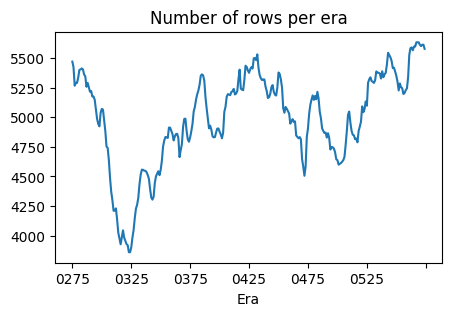

In [21]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

### Target


<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

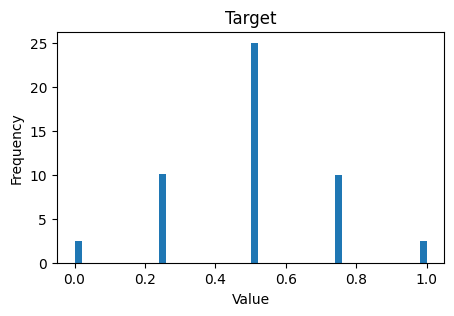

In [22]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

### Features


<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

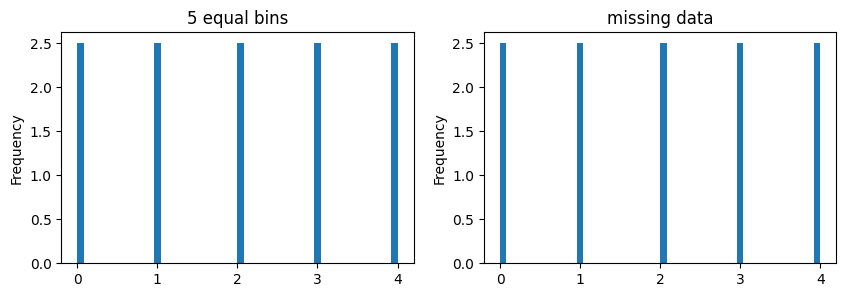

In [23]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

## 2. Modeling


### Model training



In [ ]:
# 2. Modeling — ensemble avanzato (versione ottimizzata per Colab)
import gc
import lightgbm as lgb
from sklearn.decomposition import PCA
from numerai_tools.scoring import numerai_corr
from typing import List, Tuple
import numpy as np
import pandas as pd

# Usa il DEBUG definito sopra nel notebook, se esiste
DEBUG = globals().get("DEBUG", False)


def make_era_splits(
    eras: np.ndarray,
    n_splits: int = 4,
    embargo_eras: int = 4
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Crea splits walk-forward per era con embargo.
    """
    eras = np.sort(np.unique(eras))
    n_eras = len(eras)
    split_size = n_eras // (n_splits + 1)

    splits: List[Tuple[np.ndarray, np.ndarray]] = []
    for i in range(n_splits):
        train_end = split_size * (i + 1)
        val_start = train_end + embargo_eras
        val_end = min(val_start + split_size, n_eras)
        if val_start >= n_eras or val_start >= val_end:
            break
        train_eras = eras[:train_end]
        val_eras = eras[val_start:val_end]
        splits.append((train_eras, val_eras))
    return splits


def eras_to_index(df: pd.DataFrame, train_eras, val_eras):
    train_idx = df.index[df["era"].isin(train_eras)].values
    val_idx = df.index[df["era"].isin(val_eras)].values
    return train_idx, val_idx


def neutralize_series(
    series: pd.Series,
    exposures: np.ndarray,
    proportion: float = 1.0
) -> pd.Series:
    """
    Neutralizza le previsioni rispetto alle componenti principali (PCA) delle feature.
    """
    s = series.values.reshape(-1, 1)
    x = exposures

    # normalizza ogni colonna di exposure
    x = x / (np.sqrt((x ** 2).sum(axis=0, keepdims=True)) + 1e-8)

    # proiezione e rimozione della componente spiegata
    correction = x @ np.linalg.pinv(x).dot(s)
    neutralized = s - proportion * correction
    neutralized = neutralized.ravel()

    # standardizza (z-score)
    neutralized = (neutralized - neutralized.mean()) / (neutralized.std() + 1e-8)
    return pd.Series(neutralized, index=series.index)


def to_rank(preds: pd.Series) -> pd.Series:
    """
    Converte in rank normalizzato (molto importante per Numerai).
    Range ~ [-0.5, 0.5].
    """
    return preds.rank(method="first").values / (len(preds) + 1) - 0.5


class NumeraiEnsembleModel:
    def __init__(
        self,
        feature_cols,
        target_cols,
        n_splits: int = 4,
        embargo_eras: int = 4
    ):
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        self.n_splits = n_splits
        self.embargo_eras = embargo_eras

        self.models = {t: [] for t in target_cols}
        self.target_weights = {t: 1.0 for t in target_cols}
        self.pca = None
        self.per_era_corr = {}

    def _lgb_params(self):
        """
        Parametri un po' più leggeri ma comunque aggressivi.
        In DEBUG abbassiamo n_estimators per andare più veloci.
        """
        return dict(
            objective="regression",
            n_estimators=512 if DEBUG else 2048,
            learning_rate=0.02,
            max_depth=-1,  # lascia l'albero libero
            num_leaves=255,
            # CHIAVE: permetti a LightGBM di fare split
            min_data_in_leaf=100,  # prima era 4000 (troppo grande)
            # uso nomi "classici" LGBMRegressor
            colsample_bytree=0.4,
            subsample=0.8,
            subsample_freq=1,
            reg_lambda=0.1,  # L2 regularization
            n_jobs=-1,
        )

    def fit(self, train: pd.DataFrame):
        eras = train["era"].values
        splits = make_era_splits(
            eras,
            n_splits=self.n_splits,
            embargo_eras=self.embargo_eras
        )

        # --- PCA su un campione per non ammazzare la RAM ---
        pca_sample = train[self.feature_cols].sample(
            n=min(300_000, len(train)),
            random_state=42
        )
        n_pcs = min(8, len(self.feature_cols))
        self.pca = PCA(n_components=n_pcs, random_state=42)
        self.pca.fit(pca_sample.values)

        # Out-of-fold predictions per target (per pesare i target)
        self.oof_preds = {
            t: pd.Series(0.0, index=train.index, dtype="float32")
            for t in self.target_cols
        }
        self.oof_counts = {
            t: pd.Series(0, index=train.index, dtype="int32")
            for t in self.target_cols
        }
        self.per_era_corr = {t: None for t in self.target_cols}

        for split_id, (train_eras, val_eras) in enumerate(splits):
            print(f"=== Split {split_id+1}/{len(splits)} ===")

            tr_idx, val_idx = eras_to_index(train, train_eras, val_eras)
            X_tr = train.loc[tr_idx, self.feature_cols].astype("float32")
            X_val = train.loc[val_idx, self.feature_cols].astype("float32")

            expo_tr = self.pca.transform(X_tr.values)
            expo_val = self.pca.transform(X_val.values)

            for target in self.target_cols:
                y_tr = train.loc[tr_idx, target].astype("float32")
                y_val = train.loc[val_idx, target].astype("float32")

                model = lgb.LGBMRegressor(**self._lgb_params())
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    eval_metric="l2",
                    callbacks=[
                        lgb.early_stopping(
                            stopping_rounds=100,
                            verbose=False
                        )
                    ]
                )

                self.models[target].append(model)

                val_raw = pd.Series(
                    model.predict(X_val),
                    index=train.loc[val_idx].index
                )
                val_neut = neutralize_series(val_raw, expo_val, proportion=1.0)
                val_pred = to_rank(val_neut).astype("float32")

                # niente FutureWarning: castiamo a float32 prima
                self.oof_preds[target].loc[val_idx] += val_pred
                self.oof_counts[target].loc[val_idx] += 1

            # libera RAM a ogni split
            del X_tr, X_val, expo_tr, expo_val, y_tr, y_val
            gc.collect()

        # media OOF per ogni target
        for t in self.target_cols:
            mask = self.oof_counts[t] > 0
            # solo dove abbiamo almeno una predizione OOF
            self.oof_preds[t].loc[mask] = (
                self.oof_preds[t].loc[mask] / self.oof_counts[t].loc[mask]
            )
            # dove non abbiamo OOF, mettiamo NaN
            self.oof_preds[t].loc[~mask] = np.nan

        # calcolo sharpe per target, da usare come peso
        for t in self.target_cols:
            print(f"\n### Valutazione target {t} (OOF) ###")

            df_tmp = train[["era", t]].copy()
            df_tmp["prediction"] = self.oof_preds[t]

            # tieni solo righe con OOF prediction valida
            df_tmp = df_tmp.dropna(subset=["prediction", t])

            if df_tmp.empty:
                print("Nessuna OOF valida per questo target, Sharpe = 0")
                self.per_era_corr[t] = pd.Series(dtype="float32")
                self.target_weights[t] = 0.0
                continue

            def _corr_wrapper(x: pd.DataFrame) -> float:
                v = numerai_corr(x[["prediction"]], x[t])
                if isinstance(v, pd.Series):
                    return float(v.values[0])
                return float(v)

            per_era_corr = df_tmp.groupby("era", observed=True).apply(
                _corr_wrapper,
            )

            # ripulisci NaN e inf
            per_era_corr_vals = per_era_corr.replace(
                [np.inf, -np.inf], np.nan
            ).dropna()

            if len(per_era_corr_vals) == 0:
                print("Tutte le CORR per era sono NaN, Sharpe = 0")
                self.per_era_corr[t] = per_era_corr_vals
                mean_corr = 0.0
                std_corr = 0.0
                sharpe = 0.0
            else:
                self.per_era_corr[t] = per_era_corr_vals
                mean_corr = float(per_era_corr_vals.mean())
                std_corr = float(per_era_corr_vals.std(ddof=0))

                # se lo std è praticamente 0, evitiamo Sharpe assurdi
                if std_corr < 1e-6:
                    sharpe = 0.0
                else:
                    sharpe = mean_corr / std_corr

            print(f"mean CORR: {mean_corr:.5f}")
            print(f"std CORR:  {std_corr:.5f}")
            print(f"Sharpe:    {sharpe:.3f}")

            # usiamo solo Sharpe non-negativo
            self.target_weights[t] = max(float(sharpe), 0.0)


        # normalizziamo i pesi per i target, gestendo NaN / casi degeneri
        total_w = sum(
            w for w in self.target_weights.values()
            if np.isfinite(w)
        )
        if (not np.isfinite(total_w)) or (total_w <= 0):
            # fallback: pesi uguali
            self.target_weights = {t: 1.0 for t in self.target_cols}
            total_w = float(len(self.target_cols))

        for t in self.target_cols:
            self.target_weights[t] = float(self.target_weights[t]) / total_w
            # nel caso fosse rimasto NaN
            if not np.isfinite(self.target_weights[t]):
                self.target_weights[t] = 1.0 / total_w

        print("\nPesi finali dei target nel meta-ensemble:")
        for t, w in self.target_weights.items():
            print(f"{t}: {w:.3f}")

    def _predict_single_target(self, df: pd.DataFrame, target: str) -> pd.Series:
        X = df[self.feature_cols].astype("float32")
        expo = self.pca.transform(X.values)

        preds_raw = np.mean(
            [m.predict(X) for m in self.models[target]],
            axis=0
        )

        s_raw = pd.Series(preds_raw, index=df.index)
        s_neut = neutralize_series(s_raw, expo, proportion=1.0)
        s_rank = to_rank(s_neut)

        return s_rank

    def predict(self, df: pd.DataFrame) -> pd.Series:
        """
        Ritorna sempre un pandas.Series indicizzato come df.index
        (mai un numpy array), così possiamo usare .to_frame("prediction").
        """
        target_preds = {}
        for t in self.target_cols:
            target_preds[t] = self._predict_single_target(df, t)

        final = None
        for t, s in target_preds.items():
            w = self.target_weights.get(t, 1.0 / len(self.target_cols))
            if final is None:
                final = w * s
            else:
                final = final + w * s

        # fallback difensivo
        if final is None:
            final = pd.Series(0.5, index=df.index, dtype="float32")

        # se per qualche motivo fosse un array, convertiamo
        if not isinstance(final, pd.Series):
            final = pd.Series(final, index=df.index)

        return final


# --- allena il modello ensemble sul train ---
ensemble_model = NumeraiEnsembleModel(
    feature_cols=feature_set,
    target_cols=target_cols,
    n_splits=2 if DEBUG else 4,  # meno split in DEBUG per andare piu veloce
    embargo_eras=4
)
ensemble_model.fit(train)


### Validation predictions


In [ ]:
# Validation predictions con ensemble

napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type"] + target_cols + feature_set
)
validation = validation[validation["data_type"] == "validation"].copy()
del validation["data_type"]

# (opzionale) downsample per test veloce
# validation = validation[validation["era"].isin(validation["era"].unique()[::2])]

# embargo iniziale come nell'hello world
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# prediction con ensemble
validation["prediction"] = ensemble_model.predict(validation)

validation[["era", "prediction", "target"]]


### Performance evaluation


In [ ]:
# Performance evaluation con ensemble (CORR + MMC) — versione corretta
from numerai_tools.scoring import numerai_corr, correlation_contribution

# scarica meta_model per le ere di validation
napi.download_dataset("v4.3/meta_model.parquet", round_num=842)
meta_model = pd.read_parquet("v4.3/meta_model.parquet")["numerai_meta_model"]
validation["meta_model"] = meta_model.reindex(validation.index)

def _corr_wrapper_val(x: pd.DataFrame) -> float:
    v = numerai_corr(x[["prediction"]], x["target"])
    if isinstance(v, pd.Series):
        return float(v.values[0])
    return float(v)

def _mmc_wrapper_val(x: pd.DataFrame) -> float:
    v = correlation_contribution(
        x[["prediction"]],
        x["meta_model"],
        x["target"],
    )
    if isinstance(v, pd.Series):
        return float(v.values[0])
    return float(v)

# CORR per era
per_era_corr_vals = validation.groupby("era", observed=True).apply(
    _corr_wrapper_val,
)

# MMC per era
per_era_mmc_vals = validation.dropna().groupby("era", observed=True).apply(
    _mmc_wrapper_val,
)

# Plot per-era (CORR e MMC)
per_era_corr_vals.plot(
    title="Validation CORR (ensemble)",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
)

per_era_mmc_vals.plot(
    title="Validation MMC (ensemble)",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False,
)

# Plot cumulativo
per_era_corr_vals.cumsum().plot(
    title="Cumulative Validation CORR",
    kind="line",
    figsize=(8, 4),
    legend=False,
)

per_era_mmc_vals.cumsum().plot(
    title="Cumulative Validation MMC",
    kind="line",
    figsize=(8, 4),
    legend=False,
)

# metriche riassuntive (numeri scalari)
def summarize(series: pd.Series):
    series = series.astype(float)
    mean = float(series.mean())
    std = float(series.std(ddof=0))
    sharpe = mean / (std + 1e-8)
    mdd = float(
        (series.cumsum().expanding(min_periods=1).max() - series.cumsum()).max()
    )
    return mean, std, sharpe, mdd

corr_mean, corr_std, corr_sharpe, corr_mdd = summarize(per_era_corr_vals)
mmc_mean, mmc_std, mmc_sharpe, mmc_mdd = summarize(per_era_mmc_vals)

metrics_df = pd.DataFrame(
    {
        "mean": [corr_mean, mmc_mean],
        "std": [corr_std, mmc_std],
        "sharpe": [corr_sharpe, mmc_sharpe],
        "max_drawdown": [corr_mdd, mmc_mdd],
    },
    index=["CORR", "MMC"],
)
metrics_df


## 3. Submissions



In [ ]:
napi.download_dataset(f"{DATA_VERSION}/live.parquet")
live_features = pd.read_parquet(
    f"{DATA_VERSION}/live.parquet",
    columns=feature_set
)

if DEBUG:
    live_features = live_features.sample(
        n=min(100_000, len(live_features)),
        random_state=42
    )

live_predictions = ensemble_model.predict(live_features)
live_submission = live_predictions.to_frame("prediction")
live_submission


### Model upload



In [ ]:
# Model upload — usa ensemble_model invece del modello semplice

import cloudpickle
import pandas as pd  # per sicurezza nel runtime Numerai

def predict(live_features: pd.DataFrame,
            _live_benchmark_models: pd.DataFrame) -> pd.DataFrame:
    """
    Funzione che Numerai chiamerà per generare le live predictions.
    Usa l'ensemble già addestrato.
    """
    preds = ensemble_model.predict(live_features)
    return preds.to_frame("prediction")

with open("numerai_ensemble_sota.pkl", "wb") as f:
    cloudpickle.dump(predict, f)

try:
    from google.colab import files
    files.download("numerai_ensemble_sota.pkl")
except:
    pass
